In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy as d_copy
import random

print(torch.__version__, torchvision.__version__)
print(torch.cuda.get_device_name(0))

1.8.0 0.2.2
GeForce RTX 3080


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#error_index = 0
vgg16_bn = torchvision.models.vgg16_bn(pretrained=True)#.to(device)
print(device)

cuda


In [3]:
# randomness 제어 
# https://hoya012.github.io/blog/reproducible_pytorch/
def set_randomness(seed=0):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
# func

# only apply for feature part (not pooling, classfier)
# because of layers.feature 
def split_layer(model,start,end):
    ct = 0
    split_model=[] # from start to Conv5_1(include ReLU)
    for name,layers in model.named_modules():
        #print(name,layer)
        #print(layers.features)
        for idx,layer in enumerate(layers.features):
            #print(idx,layer)
            if start <=idx and idx <=end :
                split_model.append(layer)
        break
    return nn.Sequential(*split_model)

def error_injection(name,num_error,start_index):
    def hook(model,input):
        start = start_index
        end = start_index + num_error
        input[0][:, start:end]=0
        print("shape :",input[0][:, start:end].size())
    return hook
'''
def hook_register(model,error_index,num_error):
    param_list = []
    handle =[]
    for name,parameter in model.named_parameters():
        if "features.34.weight" in name:
        #print(name,"size:",parameter.size())
            param_list.append(parameter)
    for name,layer in model.named_modules():
    #print(name)
        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):
            print("input",name,layer) # target layer Conv5_1
            tmp = layer.register_forward_pre_hook(error_injection(name,num_error,error_index))
            handle.append(tmp)
        if "36" in name :
            print("output",name,layer)
            tmp = layer.register_forward_pre_hook(name)
            handle.append(tmp)
    return param_list,handle
'''

'\ndef hook_register(model,error_index,num_error):\n    param_list = []\n    handle =[]\n    for name,parameter in model.named_parameters():\n        if "features.34.weight" in name:\n        #print(name,"size:",parameter.size())\n            param_list.append(parameter)\n    for name,layer in model.named_modules():\n    #print(name)\n        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):\n            print("input",name,layer) # target layer Conv5_1\n            tmp = layer.register_forward_pre_hook(error_injection(name,num_error,error_index))\n            handle.append(tmp)\n        if "36" in name :\n            print("output",name,layer)\n            tmp = layer.register_forward_pre_hook(name)\n            handle.append(tmp)\n    return param_list,handle\n'

In [4]:
!ls /media/0/hwbae0326/F4F

0624_models		      kdw_F4F.ipynb
0624_to_34models	      make_F4F_keras.ipynb
0624_to_34models_petImage     make_F4F_pytorch.ipynb
acc_log_to34.txt	      make_F4F_pytorch-to34.ipynb
acc_log.txt		      models
autoencoder_model.ipynb       model_test
F4F_addDense.py		      output.txt
F4F_keras.ipynb		      README.md
F4F_pytorch.ipynb	      tmp.txt
Filter_for_Filter_result.txt  trythis.ipynb
find_corelation


In [5]:
# dataset load
batch_size = 16 # 32~ out of memory in 3080
num_train = 128000
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset_path = "/media/1/Imagenet_dup/"
retrain_model_path = "/media/0/hwbae0326/F4F/0624_models/"
# imagenet data load
train_dataset = dataset.ImageFolder(root=dataset_path+"train",
                                       transform=transform)

subset_train_dataset,_ = torch.utils.data.random_split(train_dataset, [num_train,len(train_dataset)-num_train])

test_dataset = dataset.ImageFolder(root=dataset_path+"val",
                                       transform=transform)
'''
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                        batch_size=64,
                                        shuffle=False,
                                        num_workers=4)
'''

train_dataloader = torch.utils.data.DataLoader(subset_train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4) # for using subset
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=4)
print(len(train_dataloader),len(test_dataloader))

8000 3125


In [6]:
seed = 0
set_randomness(seed)

In [7]:
# external variable in error_index, num_error

def make_error_info(error_index, num_error):
    data = []
    for i in range(511,-1,-1):
        if error_index <= i and i < error_index+num_error:
            data.append(1)
        else :
            data.append(0)
        #print(data)
    error_info = torch.Tensor(data)
    error_info  = error_info.unsqueeze(0).repeat(512,1)
        #print(error_info)
    return error_info # 512,521
class F4F(nn.Module):
    def __init__(self):
        super().__init__()
        self.f4f = nn.Linear(3*3*512+512,3*3*512) # 4167,4608 filter which change feature.34 (Conv5_1)
        # 512 x5120 사이즈로 batch 저장
        #print(type(self.f4f.weight))
        self.f4f_optimizer = torch.optim.SGD([self.f4f.weight,self.f4f.bias],lr=0.0005,weight_decay=1e-4)
    def get_f4f_weight(self):
        # fc.weight.size(),fc.bias.size()
        return self.f4f.weight # torch.Size([4608, 5120])
    def forward(self,x):
        x = self.f4f(x)
        y = torch.tanh(x)
        return y
        

In [8]:
class Target_model(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
    def get_layer(self,idx):
        #print(self.model._modules['34'])
        return self.model._modules[str(idx)]
    def apply_f4f(self,f4f,error_info):
            #print(len(self.get_layer(34).weight.data))
            #print(self.get_layer(34).weight.data.size())
        weight = torch.reshape(self.get_layer(34).weight.data,(512,512*3*3)).to(device) # flatten [512,5210] (batch 512)
            #print(weight.size(),error_info.size())
        data = torch.cat( (weight,error_info), 1 )
            #print(data.size())
        offset = torch.reshape(f4f(data),(512,512,3,3))
        offset = torch.tanh(offset)
        self.get_layer(34).weight.data = self.get_layer(34).weight.data + offset
            #break # for debug
    def forward(self,x,f4f,error_info):
        # apply_f4f는 매 epoch마다 동일하므로 
        self.apply_f4f(f4f,error_info)
        y = self.model(x)
        return y
class Test_model(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
    def get_layer(self,idx):
        return self.model.features._modules[str(idx)]
    def apply_f4f(self,f4f,error_info):
        weight = torch.reshape(self.get_layer(34).weight.data,(512,512*3*3)).to(device) # flatten [512,5210] (batch 512)
        data = torch.cat( (weight,error_info), 1 )
        offset = torch.reshape(f4f(data),(512,512,3,3))
        offset = torch.tanh(offset)
        self.get_layer(34).weight.data = self.get_layer(34).weight.data + offset
            #break # for debug
    def forward(self,x,f4f,error_info):
        # apply_f4f는 매 epoch마다 동일하므로 
        self.apply_f4f(f4f,error_info)
        y = self.model(x)
        return y

In [9]:
In_layer_number = 34 # 34 conv5_1 convolution
Out_layer_number = 36 # 36 conv5_1 relu 
error_index=0
max_epochs = 30
num_error = 128
#optimizer = torch.optim.SGD(param_list,lr=0.01,weight_decay=1e-4)

In [10]:
def hook_register(model,error_index,num_error):
    for name,layer in model.named_modules():
        #print(name,layer)
        if "34" in name  and isinstance(layer, torch.nn.modules.conv.Conv2d):
            print("input",name,layer) # target layer Conv5_1
            layer.register_forward_pre_hook(error_injection(name,num_error,error_index))
        break

In [11]:
split_model = split_layer(vgg16_bn,0,36)
#print(split_model)
original_model = d_copy(split_model).to(device)
#param_list,handle = hook_register(split_model,error_index,num_error)

hook_register(split_model,error_index,num_error)
target_model = Target_model(split_model).to(device)
target_model.get_layer(In_layer_number)

test = d_copy(vgg16_bn).to(device)
hook_register(test,error_index,num_error)
test_model = Test_model(test).to(device)

In [12]:
vgg16_bn.features._modules['34']

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
'''
f4f = F4F().to(device)
total = 0
correct=0
f = open("./tmp.txt","w")
f.close()
for i,data in enumerate(train_dataloader):
    inputs,labels = data
    error_info = make_error_info(error_index,num_error).to(device)
    #print(inputs.size())
    inputs,labels = inputs.to(device), labels.to(device)
    y_hat = test_model(inputs,f4f,error_info)
    _, predicted = torch.max(y_hat.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    if(i%200 == 30):
        print(correct,total)
        print("step : %d / %d acc : %.3f"
              %(i + 1, int(len(train_dataloader)/labels.size(0)), correct*100/total))
        f = open("./tmp.txt","a")
        print("step : %d / %d acc : %.3f"
              %(i + 1, int(len(train_dataloader)/labels.size(0)), correct*100/total),file=f)
        f.close()
        break
'''
    

'\nf4f = F4F().to(device)\ntotal = 0\ncorrect=0\nf = open("./tmp.txt","w")\nf.close()\nfor i,data in enumerate(train_dataloader):\n    inputs,labels = data\n    error_info = make_error_info(error_index,num_error).to(device)\n    #print(inputs.size())\n    inputs,labels = inputs.to(device), labels.to(device)\n    y_hat = test_model(inputs,f4f,error_info)\n    _, predicted = torch.max(y_hat.data, 1)\n    total += labels.size(0)\n    correct += (predicted == labels).sum().item()\n    if(i%200 == 30):\n        print(correct,total)\n        print("step : %d / %d acc : %.3f"\n              %(i + 1, int(len(train_dataloader)/labels.size(0)), correct*100/total))\n        f = open("./tmp.txt","a")\n        print("step : %d / %d acc : %.3f"\n              %(i + 1, int(len(train_dataloader)/labels.size(0)), correct*100/total),file=f)\n        f.close()\n        break\n'

In [14]:
# evaluation phasetraining
def eval(model,dataloader,epoch,f4f,error_info):

    model.cuda()
    model.eval()
    total = 0
    correct =0
    with torch.no_grad():
        print("======eval start=======")
        for i, data in enumerate(dataloader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
        
            y_hat = model(inputs,f4f,error_info)
            _, predicted = torch.max(y_hat.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if(i%200 == 199):
                print("step : %d / %d acc : %.3f"
                      %(i + 1,int(len(dataloader)/labels.size(0)), correct*100/total))
                #print(".",end="")
        print("")
    acc = 100*correct/total
    print("%dth epoch acc of %s on imagenet : %.4f %%" %(epoch, model.__class__.__name__,acc)) 
    f = open("./acc_log.txt","a")
    print("%dth epoch acc of %s on imagenet : %.4f %%" %(epoch, model.__class__.__name__,acc),file=f) 
    f.close()
    print("======eval  end ======")  
    return acc
#torch.save(vgg16_bn.state_dict(), retrain_model_path+"test_vgg16_bn_state_dict.pt")
def model_copy(model):
    return deepcopy(model.state_dict())

In [15]:
# training
def training(test_model,target_model,original_model,train_dataloader,test_dataloader,loss_fn,error_idx,num_error,max_epochs=30,subset=False):
    f4f = F4F().to(device)
    target_model.to(device)
    original_model.to(device)
    error_info = make_error_info(error_index,num_error).to(device)
    first_feature = []
    original = []
    optimizer = f4f.f4f_optimizer
    for epoch in range(max_epochs):
        running_loss = 0.0
        total_avg_loss = 0.0
        print("=====epoch %d start======"%(epoch+1))
        f4f.train()
        # update f4f filter
        #target_model.apply_f4f(f4f,error_info)
    
        # compare
        for i, data in enumerate(train_dataloader):
            print(".",end="")
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)
            
            original_out = original_model(inputs)
            target_out = target_model(inputs,f4f,error_info)
            if i == 0:
                first_feature.append(target_out[0])
                original.append(original_out[0])
                
            loss = loss_fn(original_out,target_out)
            #print(loss.size())
            running_loss += loss.item()
            target_model.model.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i % 100 == 99: 
                total_avg_loss += running_loss
                print("")
                print('[%d, %5d] loss: %.6f' % (epoch+1, i+1, running_loss/100)) 
                running_loss = 0.0
        # save weight
        total_avg_loss /= int(len(train_dataloader)/batch_size)
        acc = eval(test_model,test_dataloader,epoch,f4f,error_info)
        
        torch.save(f4f.get_f4f_weight(), 
               retrain_model_path+"%s~%s_pkt_err_f4f_epoch_%s_acc_%.4f_loss_%.4f.pt"
               %(str(error_idx).zfill(3),str(error_idx+num_error).zfill(3),
                str(epoch+1).zfill(2),acc,total_avg_loss))      
    return original_out,first_feature
                

In [16]:
loss_fn = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.SGD(param_list,lr=0.01,weight_decay=1e-4)
first_feature = []
original_out = []
f = open("./acc_log.txt","a")
print("training weight & bias",file=f)
f.close()
for error_idx in range(0,512,num_error):
    print("**********error_idx :%d, num error :%d**********"%(error_idx, num_error))
    f = open("./acc_log.txt","a")
    print("**********error_idx :%d, num error :%d**********"%(error_idx, num_error),file=f)
    f.close()
    split_model = split_layer(vgg16_bn,0,36)
    #original_model = d_copy(split_model).to(device)
    hook_register(split_model,error_index,num_error)
    target_model = Target_model(split_model).to(device)
    
    tmp= training(test_model,target_model,original_model,train_dataloader,test_dataloader,loss_fn,error_idx,num_error,10,True)
    first_feature.append(tmp[1])
    original_out.append(tmp[0])

**********error_idx :0, num error :128**********
=====epoch 1 start======
....................................................................................................
[1,   100] loss: 0.021065
....................................................................................................
[1,   200] loss: 0.020186
....................................................................................................
[1,   300] loss: 0.020240
....................................................................................................
[1,   400] loss: 0.020393
....................................................................................................
[1,   500] loss: 0.020637
....................................................................................................
[1,   600] loss: 0.020634
....................................................................................................
[1,   700] loss: 0.020875
.....................................

In [17]:
# 여기서부터는 feature 그림 보기 위한 것들입니다.
len(first_feature),len(original_out)

(4, 4)

In [18]:
len(first_feature[0])

10

In [19]:
print(original_out[0].size())
w = 10
h = 10
cols = 32
rows = 16
def feature_print(pic):
    print("test with 'after pooling 4 feature'")
    fig = plt.figure(figsize=(64,32))
    ax = []
    for i in range(cols*rows):
        ch = pic[i,:,:]
        ax.append(fig.add_subplot(rows,cols,i+1))
        ax[-1].set_title(str(i)+"th ch (14x14)")
        plt.imshow(ch)

torch.Size([16, 512, 14, 14])


In [20]:
# 기존 모델 (에러없이, f4f없이)을 통과한 결과
feature_print(original_out[0][0].cpu().detach().numpy())

test with 'after pooling 4 feature'


test with 'after pooling 4 feature'


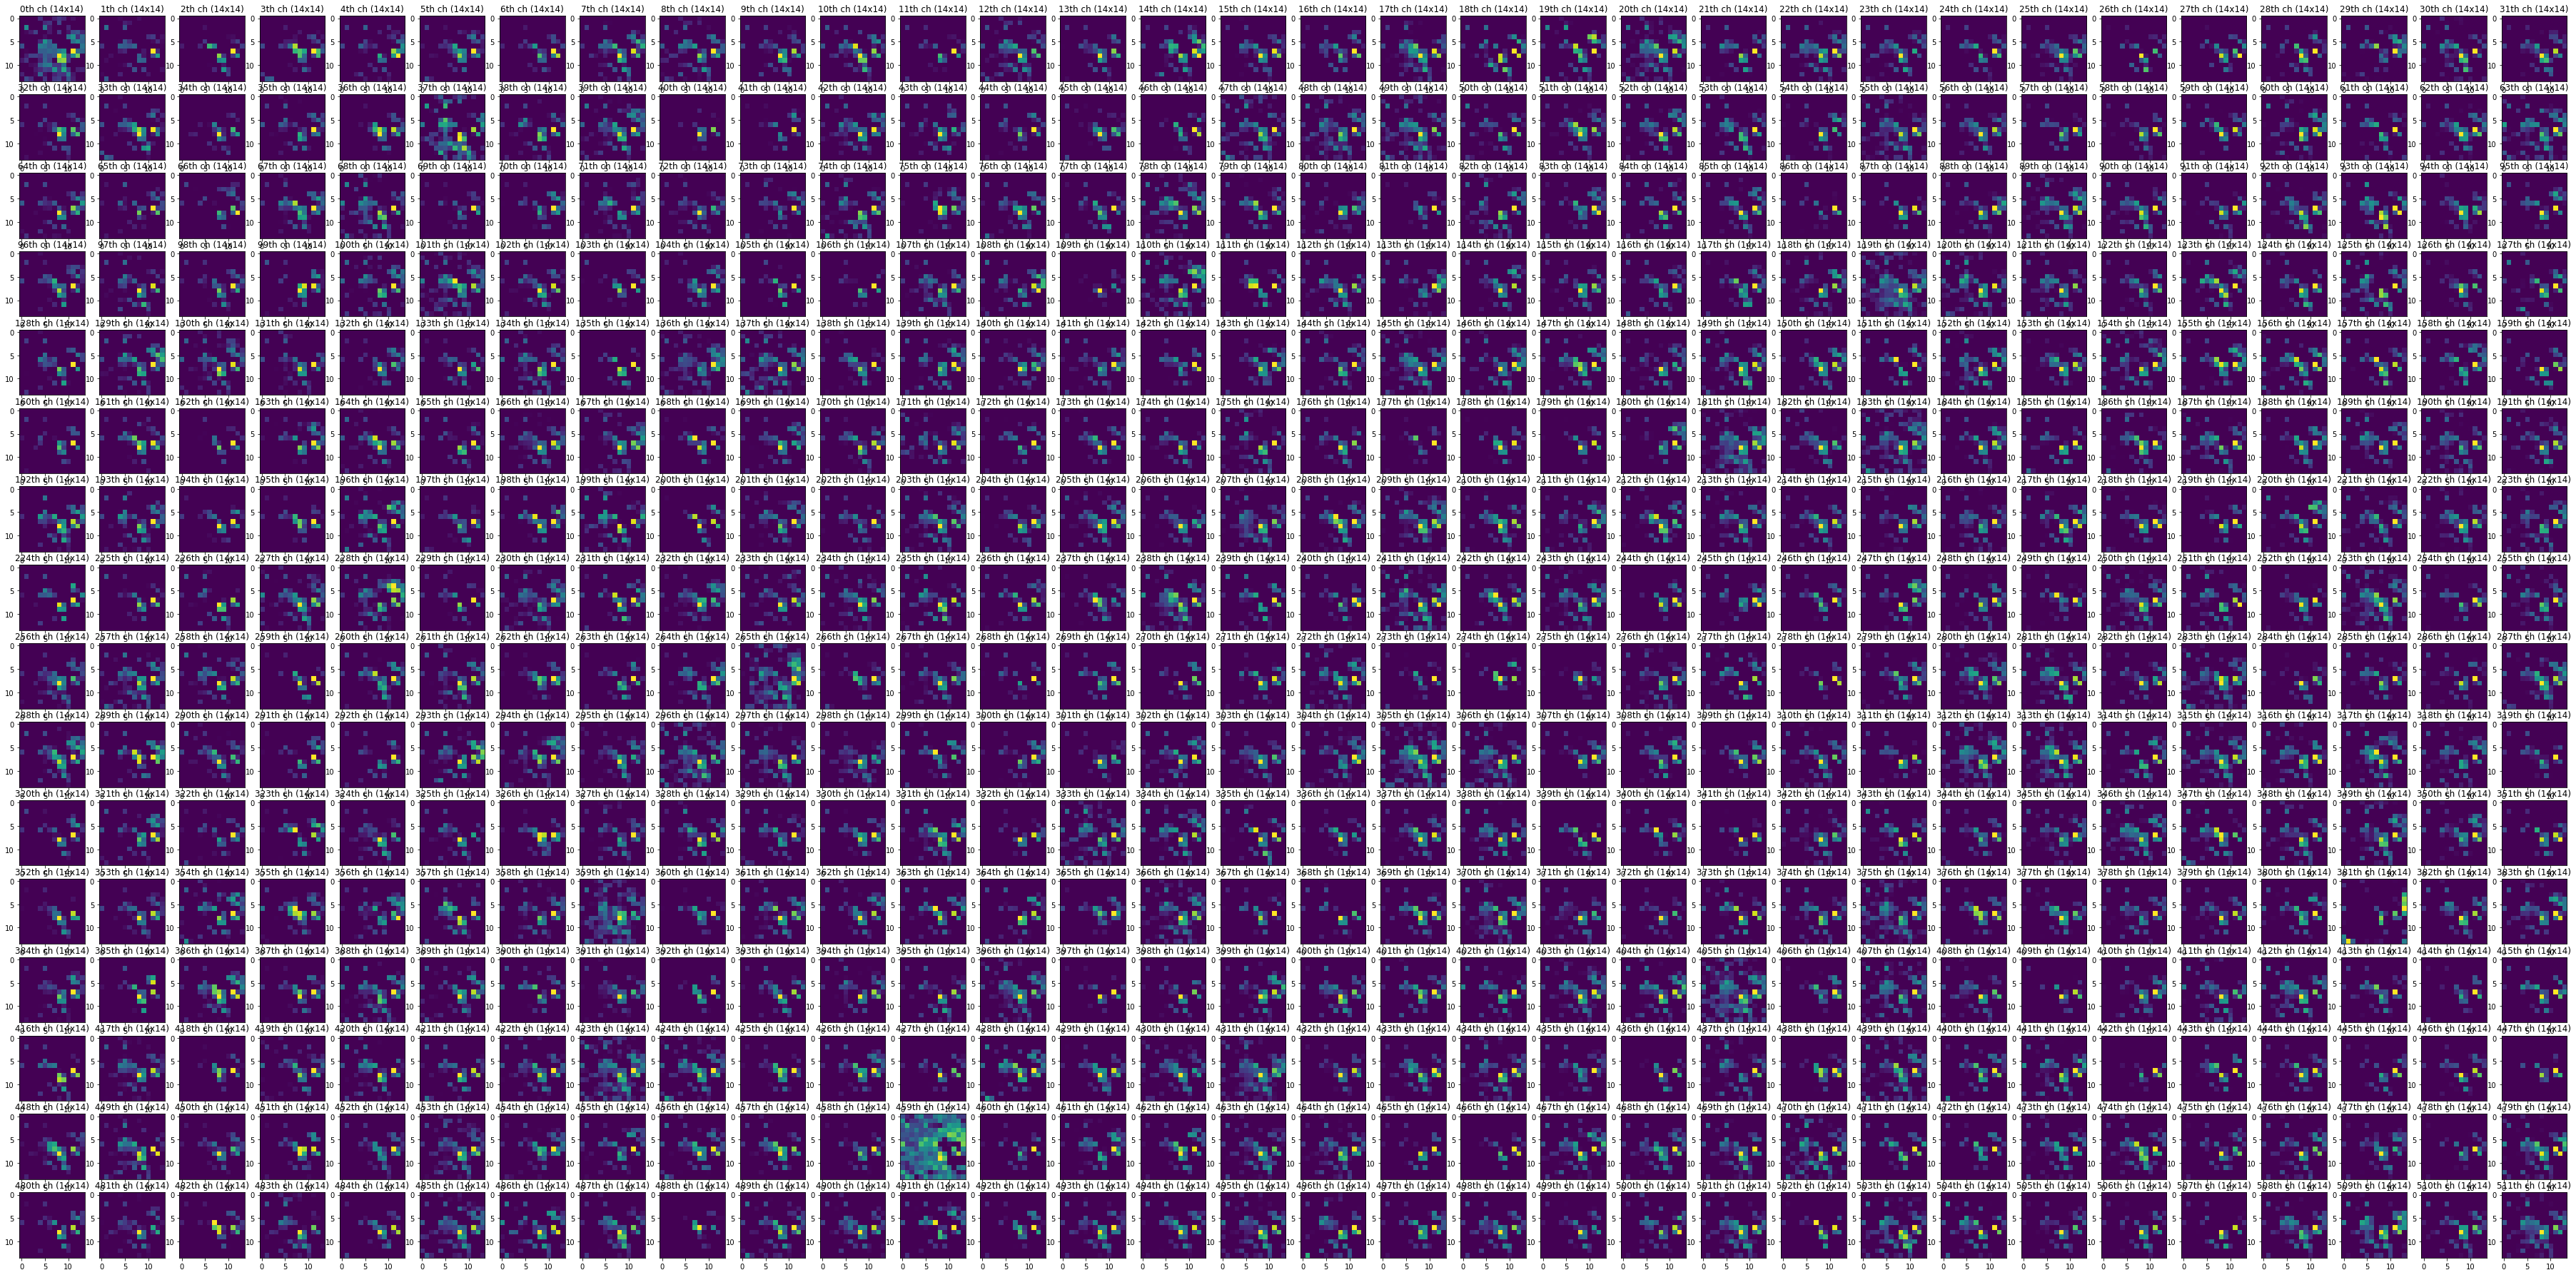

In [21]:
# f4f을 통과한 결과  epoch 1
%matplotlib inline
feature_print(first_feature[0][0].cpu().detach().numpy())

epoch 9
test with 'after pooling 4 feature'


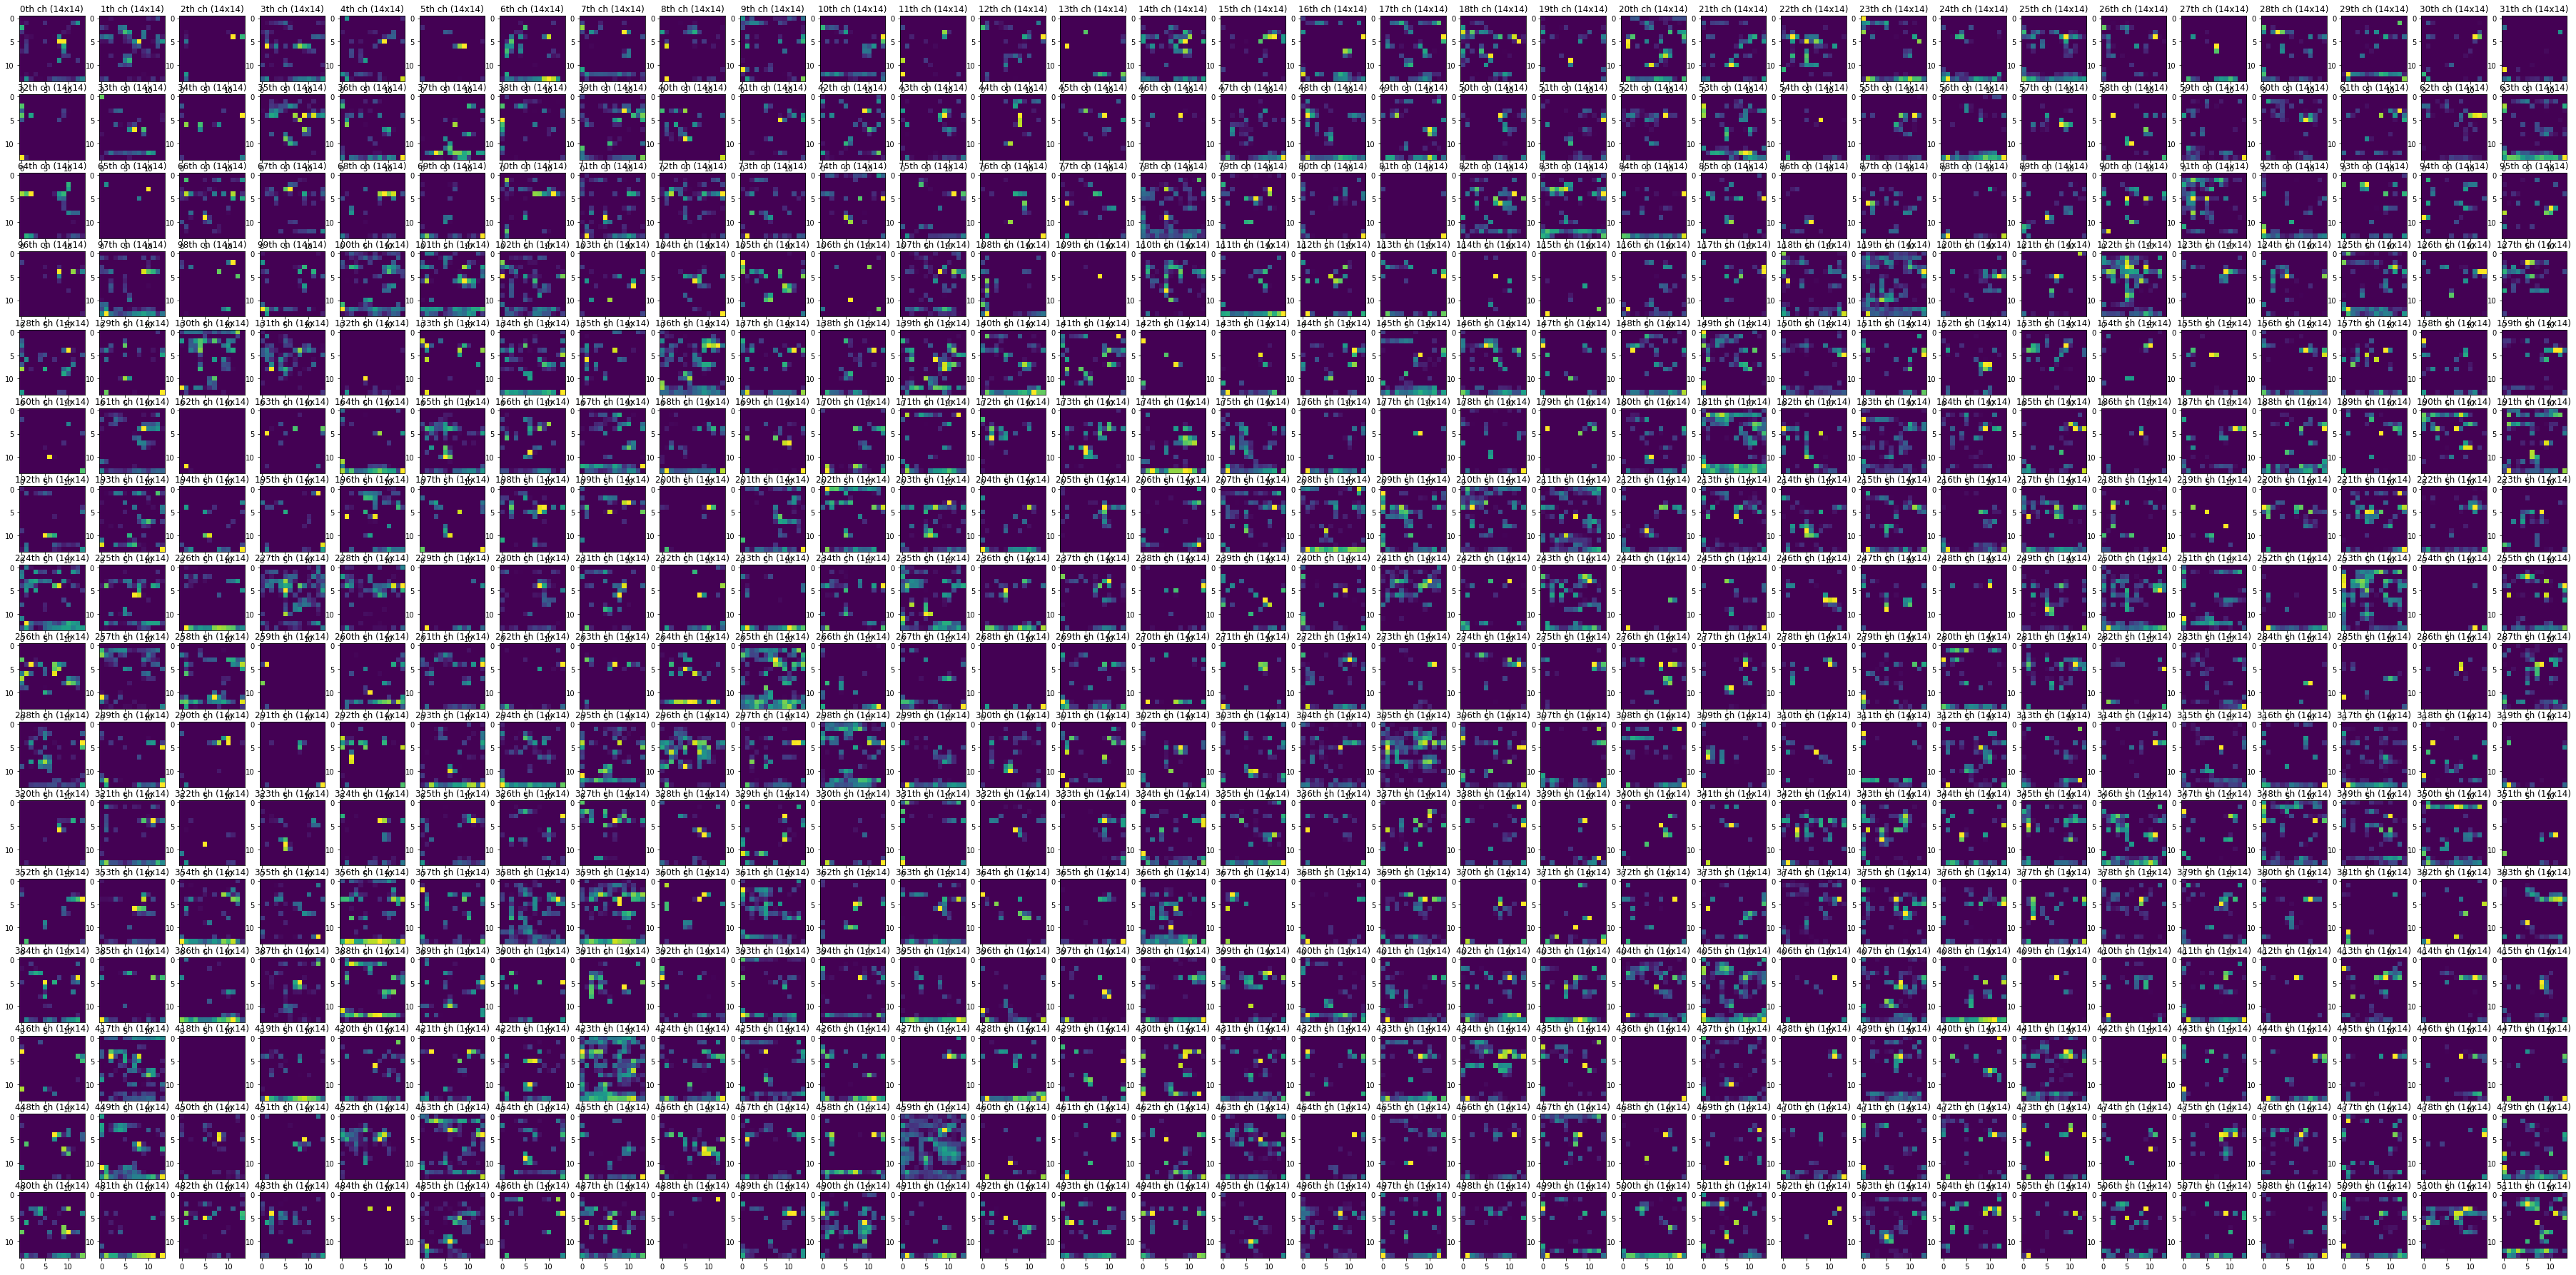

In [22]:
# f4f을 통과한 결과  epoch 9
print("epoch 9")
feature_print(first_feature[0][9].cpu().detach().numpy())

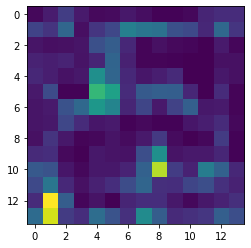

In [23]:
# 14x14 의 feature 모두 합한 결과
tmp = first_feature[0][6][0]
for i in range(1,512):
    tmp += first_feature[0][6][i]
%matplotlib inline
plt.imshow(tmp.cpu().detach())


original


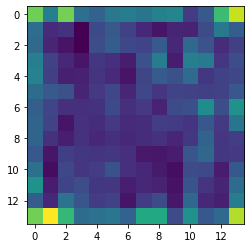

In [24]:
# 14x14 의 feature 모두 합한 결과
print("original")
tmp1 = original_out[0][6][0]
for i in range(1,512):
    tmp1 += original_out[0][6][i]
%matplotlib inline
plt.imshow(tmp1.cpu().detach())

epoch 6
test with 'after pooling 4 feature'


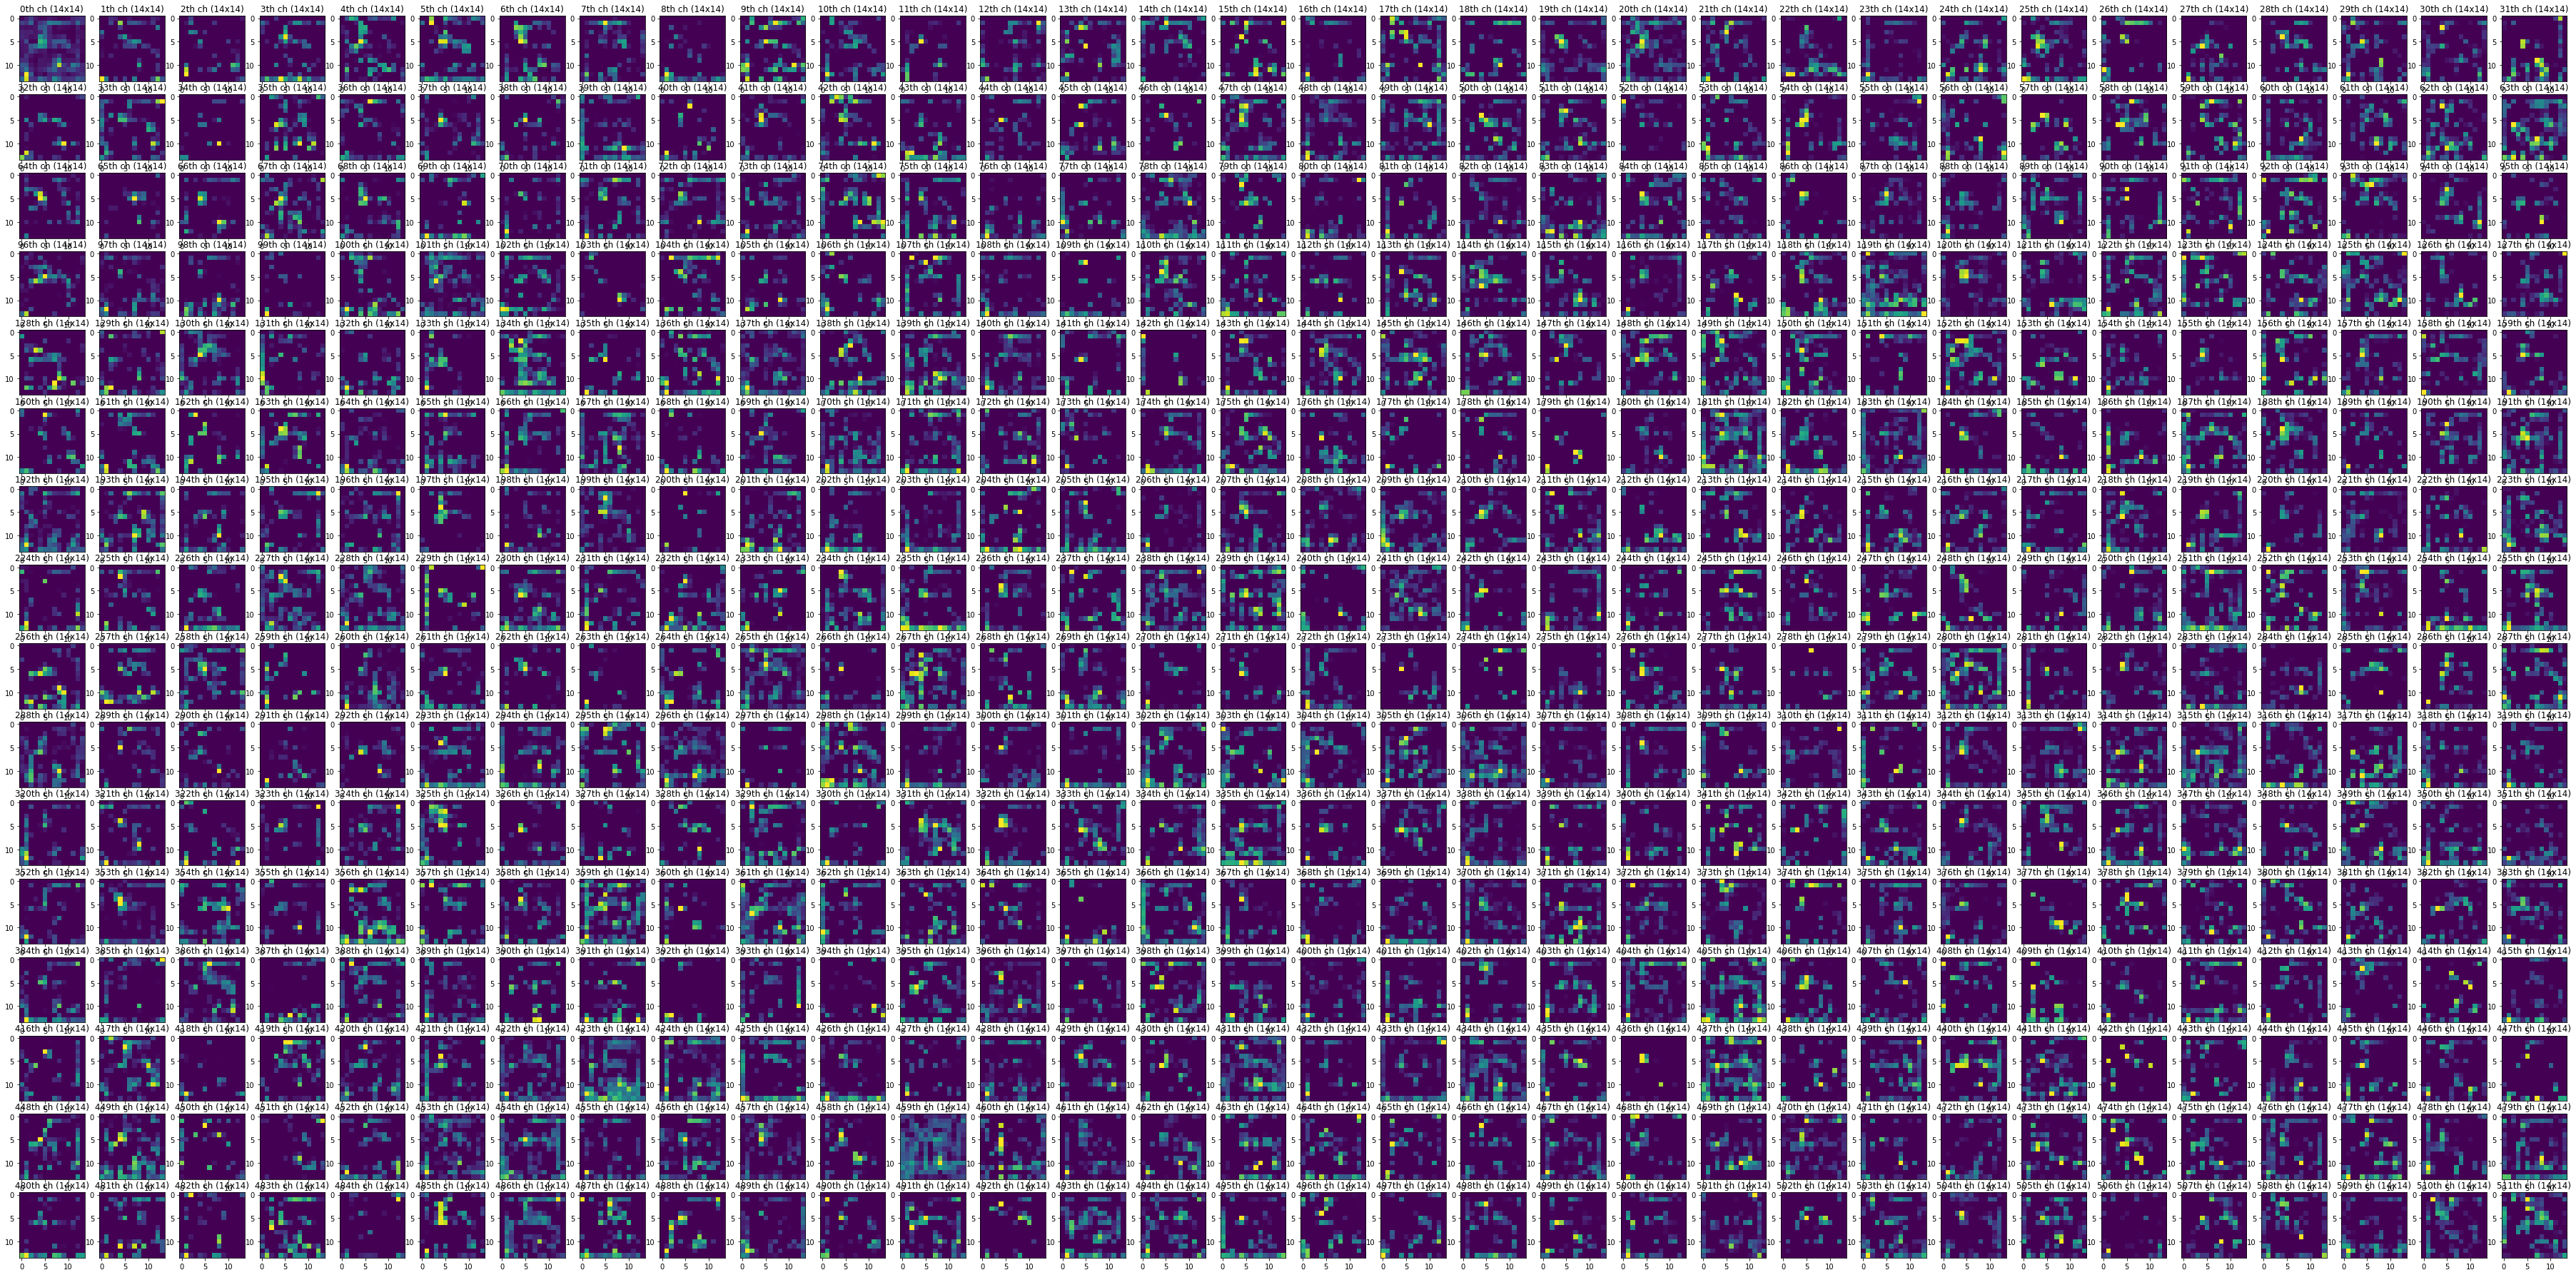

In [25]:
# f4f을 통과한 결과  epoch 6
print("epoch 6")
feature_print(first_feature[0][6].cpu().detach().numpy())